# Importations

In [11]:
!pip install timm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 16.5 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-many

In [12]:
import torch
import torchvision.models as models
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
import time
import timm
import numpy as np
from matplotlib import pyplot as plt

# DataLoading

In [3]:
transform = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4, shuffle=True)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4, shuffle=False)


100%|██████████| 170498071/170498071 [00:02<00:00, 59461440.25it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


# VGG19 model

In [4]:
model = models.vgg19(pretrained=True)

for param in model.parameters():
    param.requires_grad = False

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:07<00:00, 75.3MB/s]


In [5]:
model.features

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

block 5 conv1 is at index 28.

In [6]:
conv_indices = [28, 30, 32, 34]

for i in conv_indices:
    model.features[i].weight.requires_grad = True
    model.features[i].bias.requires_grad = True

print('trainable layers:')
for name, param in model.named_parameters():
    if param.requires_grad:
        print(name, param.requires_grad)


trainable layers:
features.28.weight True
features.28.bias True
features.30.weight True
features.30.bias True
features.32.weight True
features.32.bias True
features.34.weight True
features.34.bias True


In [7]:
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Total trainable parameters: {trainable_params}")

Total trainable parameters: 9439232


In [8]:
model.classifier

Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace=True)
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
  (4): ReLU(inplace=True)
  (5): Dropout(p=0.5, inplace=False)
  (6): Linear(in_features=4096, out_features=1000, bias=True)
)

In [9]:
model.classifier = nn.Sequential(
    nn.Flatten(),
    nn.Linear(25088, 256),
    nn.ELU(),
    nn.Dropout(0.5),
    nn.Linear(256, 10)
)

In [10]:
# model.classifier[6] = nn.Linear(model.classifier[6].in_features, 10)  # CIFAR-10 has 10 classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

In [ ]:
#hyperparamethers
learning_rate = 0.0001
num_epochs = 10
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [ ]:
all_train_loss = []
all_valid_loss = []
all_train_acc = []
all_valid_acc = []

epoch_train_loss = []
epoch_valid_loss = []
epoch_train_acc = []
epoch_valid_acc = []
epoch_train_time = []
epoch_valid_time = []


for epoch in range(num_epochs):

    # train
    t = time.time()
    epoch_loss = 0.0
    running_loss = 0.0
    total_count = 0
    correct_count = 0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        epoch_loss += loss.item()

        _, pred = torch.max(outputs.data, 1)
        total_count += labels.size(0)
        corrects = (pred==labels).sum().item()
        correct_count += corrects
        if (i+1) % 1000 == 0:
            print(f'Epoch {epoch + 1}, Batch {i + 1}: Batch Loss {running_loss / 1000:.3f}')
            all_train_loss.append(running_loss)
            running_loss = 0.0

    # end of train


    duration = time.time() - t
    epoch_train_time.append(duration)
    epoch_train_loss.append(epoch_loss/len(trainloader))
    epoch_train_acc.append(correct_count/total_count)
    print(50*'= ')
    print(f'Epoch {epoch + 1}/{num_epochs}')
    print(f'Train Loss: {epoch_loss/len(trainloader)}, Train Accuracy: {correct_count/total_count}, Train Duration: {duration}')


    # validation
    model.eval()
    t = time.time()
    running_loss = 0.0
    total_count = 0
    correct_count = 0
    with torch.no_grad():
        for i, data in enumerate(testloader, 0):
            inputs, labels = data[0].to(device), data[1].to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            _, pred = torch.max(outputs.data, 1)
            total_count += labels.size(0)
            corrects = (pred==labels).sum().item()
            correct_count += corrects

    # end of validation
    duration = time.time() - t
    epoch_valid_time.append(duration)
    epoch_valid_loss.append(running_loss/len(testloader))
    epoch_valid_acc.append(correct_count/total_count)
    print(f'Valid Loss: {running_loss/len(testloader)}, Valid Accuracy: {correct_count/total_count}, Valid Duration: {duration}')
    print(f'END of Epoch {epoch + 1}/{num_epochs}')
    print(50*'= ')
    print('\n\n')

print('Finished Training')


Epoch 1, Batch 1000: Batch Loss 1.062
Epoch 1, Batch 2000: Batch Loss 0.695
Epoch 1, Batch 3000: Batch Loss 0.595
Epoch 1, Batch 4000: Batch Loss 0.580
Epoch 1, Batch 5000: Batch Loss 0.525
Epoch 1, Batch 6000: Batch Loss 0.569
Epoch 1, Batch 7000: Batch Loss 0.524
Epoch 1, Batch 8000: Batch Loss 0.472
Epoch 1, Batch 9000: Batch Loss 0.468
Epoch 1, Batch 10000: Batch Loss 0.463
Epoch 1, Batch 11000: Batch Loss 0.443
Epoch 1, Batch 12000: Batch Loss 0.461
= = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = 
Epoch 1/10
Train Loss: 0.5663457383490746, Train Accuracy: 0.8138, Train Duration: 601.4307994842529
Valid Loss: 0.3674661717307734, Valid Accuracy: 0.8765, Valid Duration: 93.85558032989502
END of Epoch 1/10
= = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = 



Epoch 2, Batch 1000: Batch Loss 0.265
Epoch 2, Batch 2000: Batch Loss 0.291
Epoch 2, Batch 3000: Batch Loss 0.299
Epoch 2, Batc

In [ ]:
import numpy as np
# duration
average_dur_train = np.mean(np.array(epoch_train_time))
average_dur_valid = np.mean(np.array(epoch_valid_time))

print(f'train average epoch time: {average_dur_train}')
print(f'valid average epoch time: {average_dur_valid}')

train average epoch time: 598.4331702232361
valid average epoch time: 93.85982518196106


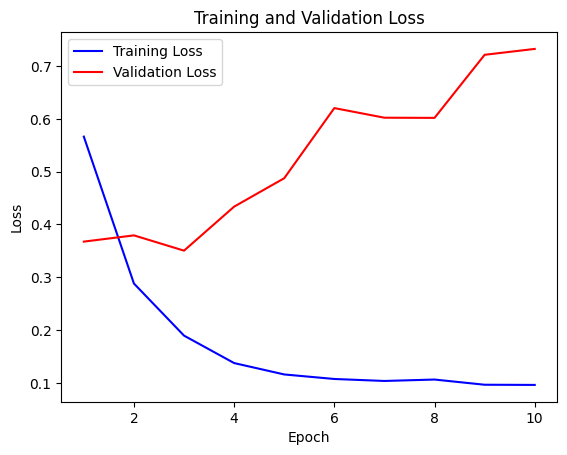

In [ ]:
# loss
epochs = range(1, num_epochs+1)
plt.plot(epochs, epoch_train_loss, label='Training Loss', color='blue')
plt.plot(epochs, epoch_valid_loss, label='Validation Loss', color='red')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()


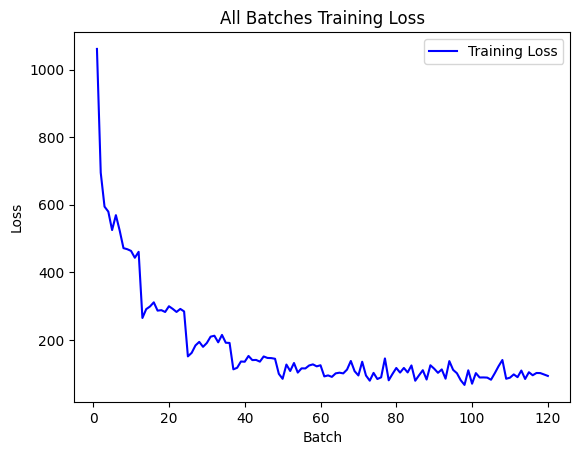

In [ ]:
from matplotlib import pyplot as plt

# loss
batches = range(1, len(all_train_loss)+1)
plt.plot(batches, all_train_loss, label='Training Loss', color='blue')
plt.xlabel('Batch')
plt.ylabel('Loss')
plt.title('All Batches Training Loss')
plt.legend()


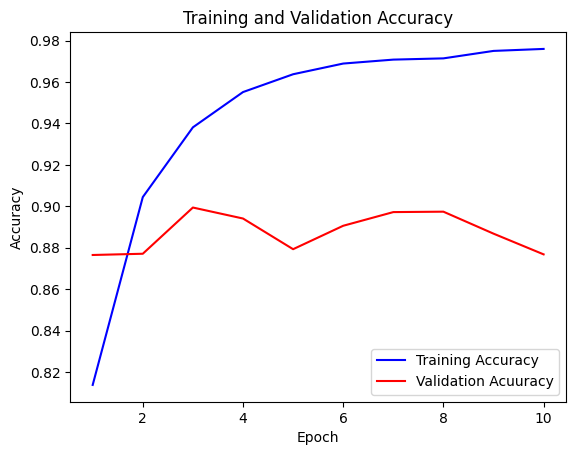

In [ ]:
# accuracy
epochs = range(1, num_epochs+1)
plt.plot(epochs, epoch_train_acc, label='Training Accuracy', color='blue')
plt.plot(epochs, epoch_valid_acc, label='Validation Acuuracy', color='red')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()


# deit_base_distilled model

In [13]:
model = timm.create_model('deit_base_distilled_patch16_224', pretrained=True)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/349M [00:00<?, ?B/s]

In [14]:
model.blocks

Sequential(
  (0): Block(
    (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
    (attn): Attention(
      (qkv): Linear(in_features=768, out_features=2304, bias=True)
      (q_norm): Identity()
      (k_norm): Identity()
      (attn_drop): Dropout(p=0.0, inplace=False)
      (proj): Linear(in_features=768, out_features=768, bias=True)
      (proj_drop): Dropout(p=0.0, inplace=False)
    )
    (ls1): Identity()
    (drop_path1): Identity()
    (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
    (mlp): Mlp(
      (fc1): Linear(in_features=768, out_features=3072, bias=True)
      (act): GELU(approximate='none')
      (drop1): Dropout(p=0.0, inplace=False)
      (norm): Identity()
      (fc2): Linear(in_features=3072, out_features=768, bias=True)
      (drop2): Dropout(p=0.0, inplace=False)
    )
    (ls2): Identity()
    (drop_path2): Identity()
  )
  (1): Block(
    (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
    (attn): Attention(
      

In [15]:
for param in model.parameters():
    param.requires_grad = False

for param in model.blocks[11].parameters():
    param.requires_grad = True

trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Total trainable parameters: {trainable_params}")

Total trainable parameters: 7087872


In [ ]:
model.head = nn.Linear(model.head.in_features, 10)
model.head_dist = nn.Linear(model.head_dist.in_features, 10)

model.classifier = nn.Sequential(
    nn.Linear(25088, 256),
    nn.ELU(),
    nn.Dropout(0.5),
    nn.Linear(256, 10)
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

VisionTransformerDistilled(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    (norm): Identity()
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (patch_drop): Identity()
  (norm_pre): Identity()
  (blocks): Sequential(
    (0): Block(
      (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=768, out_features=2304, bias=True)
        (q_norm): Identity()
        (k_norm): Identity()
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=768, out_features=768, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): Identity()
      (drop_path1): Identity()
      (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=768, out_features=3072, bias=True)
        (act): GELU(approximate='none')
        (drop1): Dropout(p=0.0, inplace=False)
        (norm): 

In [ ]:
#hyperparamethers
learning_rate = 0.0001
num_epochs = 10
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [ ]:
all_train_loss = []
all_valid_loss = []
all_train_acc = []
all_valid_acc = []

epoch_train_loss = []
epoch_valid_loss = []
epoch_train_acc = []
epoch_valid_acc = []
epoch_train_time = []
epoch_valid_time = []


for epoch in range(num_epochs):

    # train
    t = time.time()
    epoch_loss = 0.0
    running_loss = 0.0
    total_count = 0
    correct_count = 0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        epoch_loss += loss.item()

        _, pred = torch.max(outputs.data, 1)
        total_count += labels.size(0)
        corrects = (pred==labels).sum().item()
        correct_count += corrects
        if (i+1) % 1000 == 0:
            print(f'Epoch {epoch + 1}, Batch {i + 1}: Batch Loss {running_loss / 1000:.3f}')
            all_train_loss.append(running_loss)
            all_train_acc.append(correct_count/total_count)
            running_loss = 0.0

    # end of train


    duration = time.time() - t
    epoch_train_time.append(duration)
    epoch_train_loss.append(epoch_loss/len(trainloader))
    epoch_train_acc.append(correct_count/total_count)
    print(50*'= ')
    print(f'Epoch {epoch + 1}/{num_epochs}')
    print(f'Train Loss: {epoch_loss/len(trainloader)}, Train Accuracy: {correct_count/total_count}, Train Duration: {duration}')


    # validation
    model.eval()
    t = time.time()
    running_loss = 0.0
    total_count = 0
    correct_count = 0
    with torch.no_grad():
        for i, data in enumerate(testloader, 0):
            inputs, labels = data[0].to(device), data[1].to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            _, pred = torch.max(outputs.data, 1)
            total_count += labels.size(0)
            corrects = (pred==labels).sum().item()
            correct_count += corrects

    # end of validation
    duration = time.time() - t
    epoch_valid_time.append(duration)
    epoch_valid_loss.append(running_loss/len(testloader))
    epoch_valid_acc.append(correct_count/total_count)
    print(f'Valid Loss: {running_loss/len(testloader)}, Valid Accuracy: {correct_count/total_count}, Valid Duration: {duration}')
    print(f'END of Epoch {epoch + 1}/{num_epochs}')
    print(50*'= ')
    print('\n\n')

print('Finished Training')


Epoch 1, Batch 1000: Batch Loss 0.346
Epoch 1, Batch 2000: Batch Loss 0.174
Epoch 1, Batch 3000: Batch Loss 0.168
Epoch 1, Batch 4000: Batch Loss 0.144
Epoch 1, Batch 5000: Batch Loss 0.143
Epoch 1, Batch 6000: Batch Loss 0.123
Epoch 1, Batch 7000: Batch Loss 0.125
Epoch 1, Batch 8000: Batch Loss 0.133
Epoch 1, Batch 9000: Batch Loss 0.126
Epoch 1, Batch 10000: Batch Loss 0.126
Epoch 1, Batch 11000: Batch Loss 0.125
Epoch 1, Batch 12000: Batch Loss 0.119
= = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = 
Epoch 1/10
Train Loss: 0.15297047497838023, Train Accuracy: 0.95084, Train Duration: 787.7646887302399
Valid Loss: 0.11187357672396757, Valid Accuracy: 0.9626, Valid Duration: 138.7780363559723
END of Epoch 1/10
= = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = 



Epoch 2, Batch 1000: Batch Loss 0.055
Epoch 2, Batch 2000: Batch Loss 0.056
Epoch 2, Batch 3000: Batch Loss 0.074
Epoch 2, B

In [ ]:
# duration
average_dur_train = np.mean(np.array(epoch_train_time))
average_dur_valid = np.mean(np.array(epoch_valid_time))

print(f'train average epoch time: {average_dur_train}')
print(f'valid average epoch time: {average_dur_valid}')

train average epoch time: 789.7511398792267
valid average epoch time: 138.66850349903106


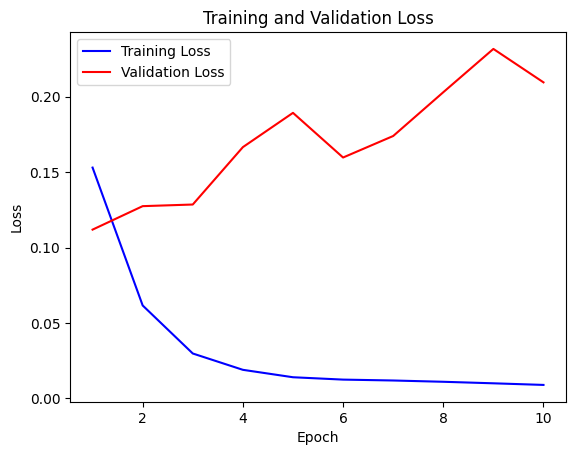

In [ ]:
# loss
epochs = range(1, num_epochs+1)
plt.plot(epochs, epoch_train_loss, label='Training Loss', color='blue')
plt.plot(epochs, epoch_valid_loss, label='Validation Loss', color='red')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()


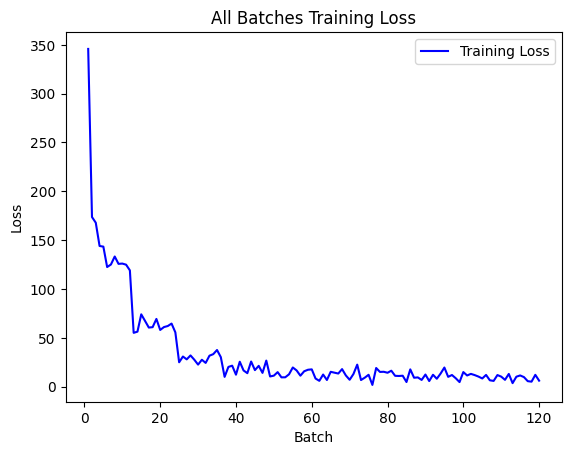

In [ ]:
# loss
batches = range(1, len(all_train_loss)+1)
plt.plot(batches, all_train_loss, label='Training Loss', color='blue')
plt.xlabel('Batch')
plt.ylabel('Loss')
plt.title('All Batches Training Loss')
plt.legend()

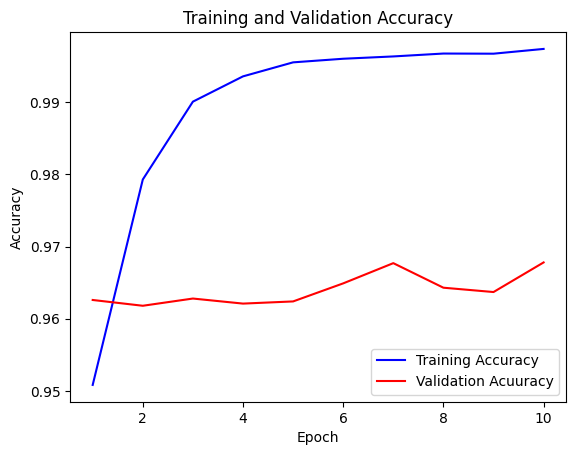

In [ ]:
# accuracy
epochs = range(1, num_epochs+1)
plt.plot(epochs, epoch_train_acc, label='Training Accuracy', color='blue')
plt.plot(epochs, epoch_valid_acc, label='Validation Acuuracy', color='red')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()


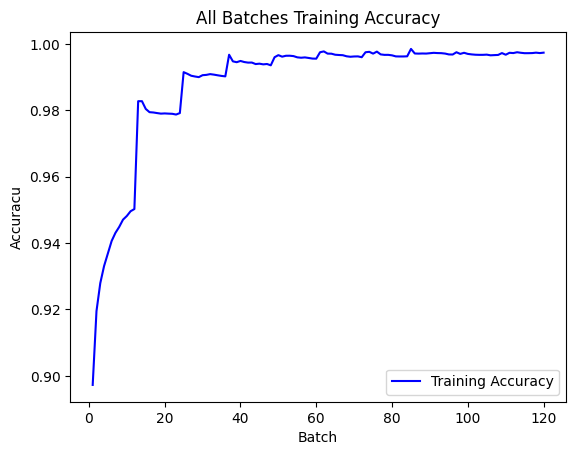

In [ ]:
# loss
batches = range(1, len(all_train_acc)+1)
plt.plot(batches, all_train_acc, label='Training Accuracy', color='blue')
plt.xlabel('Batch')
plt.ylabel('Accuracu')
plt.title('All Batches Training Accuracy')
plt.legend()